<a href="https://colab.research.google.com/github/CynthiaGichuki/Early-DR-Detection-Classification/blob/main/ENSEMBLE_VGG16_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 MODEL - BASE MODEL 1

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import os, glob
import cv2
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


DATA AUGMENTATION

In [ ]:
pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor

In [ ]:
p = Augmentor.Pipeline("/content/drive/MyDrive/WHOLEDATASET",output_directory = "/content/drive/MyDrive/Augmented3")

Initialised with 10113 image(s) found.
Output directory set to /content/drive/MyDrive/Augmented3.

In [ ]:
#p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

In [ ]:
#p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

In [ ]:
#p.sample(20500)

In [ ]:

classes = {'grade_0': 0, 'grade_1':1, 'grade_2':2, 'grade_3':3}

X = []
Y = []
for cls in classes:
  pth = '/content/drive/MyDrive/Augmented3/'+cls
  for j in os.listdir(pth):
    img = cv2.imread(pth+'/'+j)
    #cv2_imshow(img)
    try:
       img = cv2.resize(img, (224,224))
       #img = cv2.GaussianBlur(img,(10,10),0)
       X.append(img)
       Y.append(classes[cls])
    except Exception as e:
      pass


VISUALIZING DATA

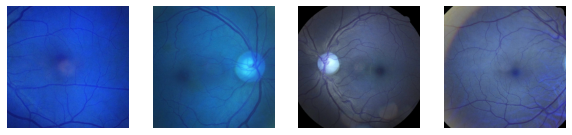

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
xtrain, xtest, ytrain, ytest =  train_test_split(X, Y, test_size=.20, random_state=42)


In [ ]:
np.unique(Y)

array([0, 1, 2, 3])

In [ ]:
import pandas as pd
pd.Series(Y).value_counts()

0    6344
1    5254
2    5237
3    3665
dtype: int64

In [ ]:
print("Shape of image in Xtrain:", xtrain[0].shape)
print("Shape of image in Xtrain:", xtest[0].shape)



Shape of image in Xtrain: (224, 224, 3)
Shape of image in Xtrain: (224, 224, 3)


In [ ]:
#le = preprocessing.LabelEncoder()
#ytrain = le.fit_transform(ytrain)
#ytest = le.fit_transform(ytest)
ytrain = tf.keras.utils.to_categorical(ytrain, num_classes=4)
ytest = tf.keras.utils.to_categorical(ytest, num_classes=4)
ytrain = np.array(ytrain)
xtrain = np.array(xtrain)
ytest = np.array(ytest)
xtest = np.array(xtest)
print("X_train Shape: ", xtrain.shape)
print("X_test Shape: ", xtest.shape)
print("y_train Shape: ", ytrain.shape)
print("y_test Shape: ", ytest.shape)

X_train Shape:  (16400, 224, 224, 3)
X_test Shape:  (4100, 224, 224, 3)
y_train Shape:  (16400, 4)
y_test Shape:  (4100, 4)


In [ ]:
import pandas as pd
pd.Series(Y).value_counts()

0    6344
1    5254
2    5237
3    3665
dtype: int64

#VGG16

In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))


# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

#printing layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
from keras import regularizers

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001))(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model1 = Model(inputs = vgg.input, outputs = FC_Head)

print(model1.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
from tensorflow.keras.models import Model
from keras.optimizers import SGD

#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/content/drive/MyDrive/VGG16/Model-{epoch:02d}={val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model1.fit(xtrain,ytrain,
                   epochs=300,callbacks=[checkpoint],
                   validation_data=(xtest,ytest),
                   verbose = 1,
                   initial_epoch=0)

Epoch 1/300
513/513 [==============================] - ETA: 0s - loss: 1.7336 - accuracy: 0.2829
Epoch 1: val_accuracy improved from -inf to 0.35146, saving model to /content/drive/MyDrive/VGG16/Model-01=0.3515.hdf5
513/513 [==============================] - 118s 208ms/step - loss: 1.7336 - accuracy: 0.2829 - val_loss: 1.4527 - val_accuracy: 0.3515
Epoch 2/300
513/513 [==============================] - ETA: 0s - loss: 1.5066 - accuracy: 0.3138
Epoch 2: val_accuracy improved from 0.35146 to 0.37854, saving model to /content/drive/MyDrive/VGG16/Model-02=0.3785.hdf5
513/513 [==============================] - 104s 202ms/step - loss: 1.5066 - accuracy: 0.3138 - val_loss: 1.4243 - val_accuracy: 0.3785
Epoch 3/300
513/513 [==============================] - ETA: 0s - loss: 1.4773 - accuracy: 0.3256
Epoch 3: val_accuracy improved from 0.37854 to 0.38244, saving model to /content/drive/MyDrive/VGG16/Model-03=0.3824.hdf5
513/513 [==============================] - 103s 202ms/step - loss: 1.4773 - 

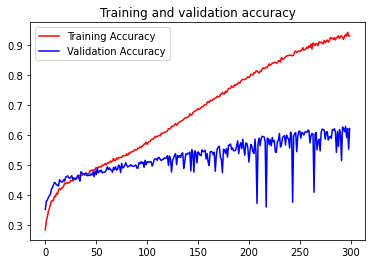

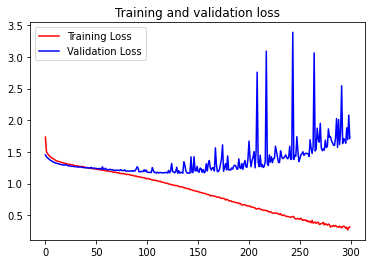

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#RESNET50

In [ ]:
from keras.applications import ResNet50


img_rows, img_cols = 224, 224


resnet = ResNet50(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in resnet.layers:
    layer.trainable = False

for (i,layer) in enumerate(resnet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

94765736/94765736 [==============================] - 3s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Con

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import regularizers

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    #top_model = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.000001))(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dropout(0.7)(top_model)
    top_model = Dense(4,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Model


num_classes = 4

FC_Head = lw(resnet, num_classes)

model2 = Model(inputs = resnet.input, outputs = FC_Head)

print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from keras.optimizers import SGD

model2.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy',metrics = ['accuracy'])

ENSEMBLE MODEL

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from sklearn.ensemble import BaggingClassifier
model_1 = load_model('/content/drive/MyDrive/ResNet50/Model-17=0.6946.hdf5')
model_1 = Model(model_1.inputs,
                model_1.outputs,
                'name_of_model_1')

model_2 = load_model('/content/drive/MyDrive/VGG16/Model-14=0.6329.hdf5')
model_2 = Model(model_2.inputs,
                model2.outputs,
                'name_of_model_2')

models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model_input for model in models]
ensemble_output = BaggingClassifier()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
ensemble_model.compile(optimizer=SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath = '/content/drive/MyDrive/Ensemble/Model-{epoch:02d}={val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = ensemble_model.fit(xtrain,ytrain,
                    epochs=300,callbacks=[checkpoint],
                    validation_data=(xtest,ytest),
                    verbose = 1,
                    initial_epoch=0, shuffle=True)

Epoch 1/300
513/513 [==============================] - ETA: 0s - loss: 1.4155 - accuracy: 0.3045
Epoch 1: val_accuracy improved from -inf to 0.36561, saving model to /content/drive/MyDrive/Ensemble/Model-01=0.3656.hdf5
513/513 [==============================] - 75s 127ms/step - loss: 1.4155 - accuracy: 0.3045 - val_loss: 1.3063 - val_accuracy: 0.3656
Epoch 2/300
513/513 [==============================] - ETA: 0s - loss: 1.3234 - accuracy: 0.3434
Epoch 2: val_accuracy improved from 0.36561 to 0.38780, saving model to /content/drive/MyDrive/Ensemble/Model-02=0.3878.hdf5
513/513 [==============================] - 62s 121ms/step - loss: 1.3234 - accuracy: 0.3434 - val_loss: 1.2735 - val_accuracy: 0.3878
Epoch 3/300
513/513 [==============================] - ETA: 0s - loss: 1.2955 - accuracy: 0.3622
Epoch 3: val_accuracy improved from 0.38780 to 0.40171, saving model to /content/drive/MyDrive/Ensemble/Model-03=0.4017.hdf5
513/513 [==============================] - 62s 120ms/step - loss: 1.2

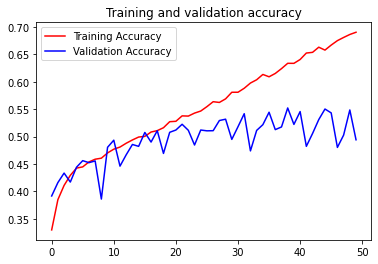

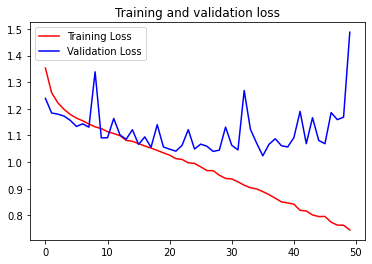

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#EVALUATION

In [ ]:
y_pred=ensemble_model.predict(xtest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(ytest, axis=1)

129/129 [==============================] - 18s 142ms/step


In [ ]:
y_pred[68]

2

In [ ]:
y_test[68]

3

In [ ]:
y_pred[57]

1

In [ ]:
y_test[57]

1

In [ ]:
import pickle

with open('model_pkl', 'wb') as files:
    pickle.dump(ensemble_model, files)

with open('model_pkl' , 'rb') as f:
    lr = pickle.load(f)
